In [1]:
import pandas as pd
from pandasql import sqldf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import random
import math

In [2]:
VARIABLES = ['ActivityCounts', 'Barometer', 'BloodPerfusion',
             'BloodPulseWave', 'EnergyExpenditure', 'GalvanicSkinResponse', 'HR',
             'HRV', 'RESP', 'Steps', 'SkinTemperature', 'ActivityClass']

In [40]:
def get_time_series(dat, variable, day):
    entry = dat[variable][day]
    time_series = np.array([value if value != 'None' else None for value in entry.split(',')], dtype=float) \
        if not isinstance(entry, np.ndarray) else entry # entry could be ndarray or string
    return time_series

def plotter(day, dat):
    """
    Plots time-series of physiological variables for specific day
    """
    plt.figure()
    plt.subplots_adjust(left=0.1,
                        bottom=0.01,
                        right=1.2,
                        top=1.5,
                        wspace=0.4,
                        hspace=0.4)
    length = len(np.array([value if value != 'None' else None for value in dat['HR'][day].split(',')], dtype=float)) \
        if not isinstance(dat['HR'][day], np.ndarray) else len(dat['HR'][day]) # entry could be ndarray or string

    for i, variable in enumerate(VARIABLES):
        time_series = get_time_series(dat, variable, day)

        assert len(time_series) == length, 'time-series data lengths differ!'

        col = 'green' if dat['VAS'][day] == 0.0 else 'red'
        plt.subplot(3, 4, i+1)
        plt.title(variable)
        plt.plot(time_series, col)
        plt.xlim([0, length])

def na_visualizer(days, dat):
    """
    Plots missing data for specific days in red/green
    """
    for day in days:
        length = get_time_series(dat, 'ActivityCounts', day).shape[0]
        n_variables = len(VARIABLES)
        na_matrix = np.zeros((n_variables, length))

        for i, variable in enumerate(VARIABLES):
            time_series = get_time_series(dat, variable, day)

            na_data = np.where(np.isnan(time_series), 0.0, 1.0) # NaN -> 0, data -> 1
            na_matrix[i, :] = na_data

        # hack: below makes sure colors in image are matched correctly (if all missing/no missing would break otherwise)
        na_matrix[1, 1] = 0.0
        na_matrix[2, 1] = 1.0

        # plot
        cmap = matplotlib.colors.ListedColormap(['red', 'green'])
        plt.figure()
        plt.imshow(na_matrix, cmap=cmap, aspect='20', interpolation='nearest')
        plt.title(f'day {day}')
        plt.xlabel('data length [min]')
        plt.ylabel('variable')

def na_sequence_lengths(dat):
    """
    Calculates lengths of missing data sequences of full dataset
    """
    # check NA sequence lengths
    n_days, n_cols = dat.shape

    total_missing_values = 0
    na_sequences_data = []
    for day in range(n_days):
        for variable in VARIABLES:
            time_series = get_time_series(dat, variable, day)

            na_sequences = []
            na_seq = 0
            for datapoint in time_series:
                if not np.isnan(datapoint):
                    if na_seq > 0:
                        na_sequences.append(na_seq)
                        total_missing_values += na_seq
                        na_seq = 0
                else:
                    # datapoint is NA
                    na_seq += 1
            na_sequences_data += na_sequences

    # show numerical distribution of NA sequence lengths
    temp = pd.DataFrame(np.array(na_sequences_data), columns=['n'])
    query = '''
    SELECT n AS sequence_length, COUNT(*) AS occurrences
    FROM temp
    GROUP BY n;'''
    temp = sqldf(query)

    # plot distribution of NA sequence lengths
    temp.plot.bar(x='sequence_length', y='occurrences', width=2, title=f'Missing data (total: {total_missing_values})')
    plt.xticks([])
    plt.xlim([-10, temp.shape[0]])

    return temp

def imputer(dat, max_fill=50, method='linear'):
    """
    Imputes missing data for full dataset
    """
    dat2 = dat.copy()

    for variable in VARIABLES:
        time_series_all_days = []
        for day in range(dat2.shape[0]):
            time_series = get_time_series(dat, variable, day)
            time_series_all_days.append(time_series)

        pre_imputation = pd.DataFrame(time_series_all_days)
        post_imputation = pre_imputation.interpolate(method=method, axis=1, limit=max_fill, limit_direction='both')

        # update dataframe with imputation data
        for day in range(dat2.shape[0]):
            dat2[variable].iloc[day] = np.array(post_imputation.iloc[day])

    return dat2

def missing_data_per_variable(dat):
    """
    Calculates missing data ratio for each variable
    """
    dat2 = dat.copy()

    missing_data_variable = {variable: [] for variable in VARIABLES}
    for variable in VARIABLES:
        for day in range(dat2.shape[0]):
            time_series = get_time_series(dat, variable, day)
            na_data = list(np.where(np.isnan(time_series), 0.0, 1.0)) # NaN -> 0, data -> 1
            missing_data_variable[variable] += na_data

    missing_data_variable = {variable: np.mean(na_data) for variable, na_data in missing_data_variable.items()}
    return missing_data_variable

# Import data

In [4]:
# file path to data folder
path = './Output'

In [5]:
file = path + f'/combined_data.csv'
data = pd.read_csv(file, index_col=0).fillna(pd.NA)

# Data analysis

Text(0, 0.5, 'available data [%]')

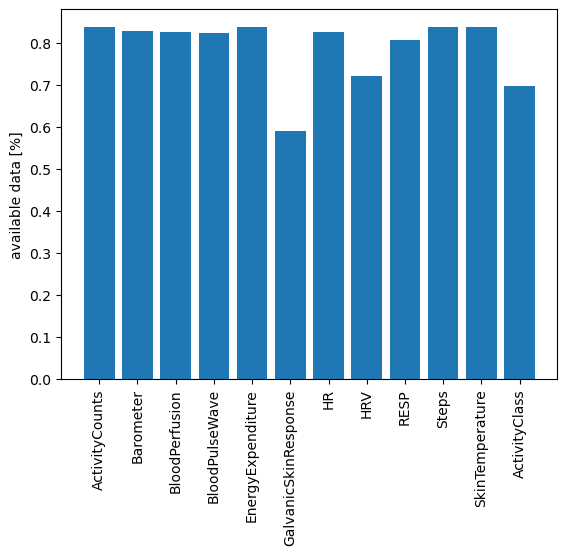

In [6]:
# missing data per variable
temp = missing_data_per_variable(data)

plt.bar(x=temp.keys(), height=temp.values())
plt.xticks(rotation=90)
plt.ylabel('available data [%]')

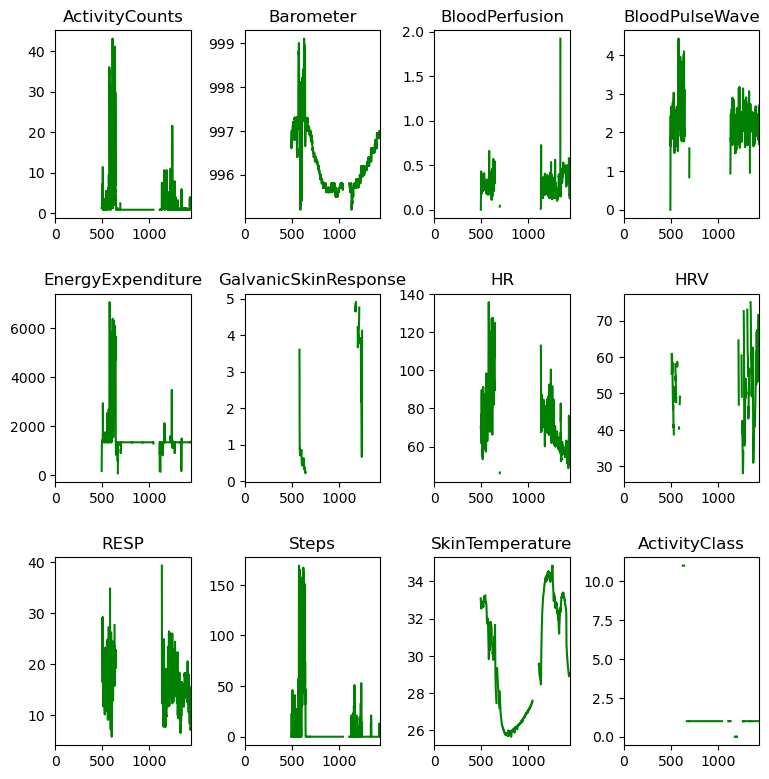

In [7]:
# visualization of time-series for random day (red: fatigued, green: vigilant)
day = random.sample(range(data.shape[0]), 1)[0]
plotter(day, data)

# Filter 1/2

Discard EDA

In [8]:
# discard EDA from dataset (too much missing data)
data = data.drop(columns=['GalvanicSkinResponse'])
VARIABLES = [variable for variable in VARIABLES if variable != 'GalvanicSkinResponse']

Mark timepoints with no data

In [9]:
# mark timepoints where all variables are missing for future filtering
rows, columns = data.shape
data.insert(columns, 'noData', [None for i in range(rows)])

In [10]:
days = range(rows)
for day in days:
    length = get_time_series(data, 'ActivityCounts', day).shape[0]
    n_variables = len(VARIABLES)
    na_matrix = np.zeros((n_variables, length))

    for i, variable in enumerate(VARIABLES):
        time_series = get_time_series(data, variable, day)

        na_data = np.where(np.isnan(time_series), 0.0, 1.0) # NaN -> 0, data -> 1
        na_matrix[i, :] = na_data

    na_matrix = np.sum(na_matrix, axis=0)

    data['noData'].iloc[day] = np.where(na_matrix == 0) # row all 0 -> no data at this time in any variable

C:\Users\jjung\AppData\Local\Temp\ipykernel_38352\3262403514.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['noData'].iloc[day] = np.where(na_matrix == 0) # row all 0 -> no data at this time in any variable


# Imputation

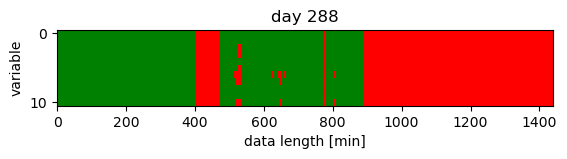

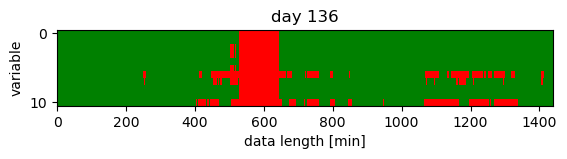

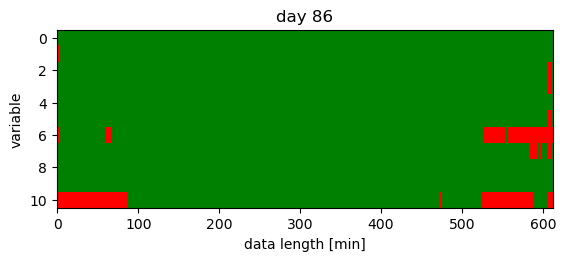

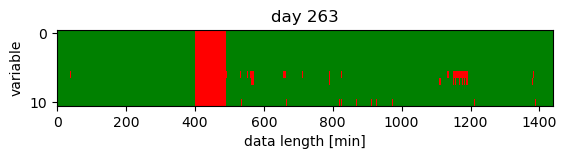

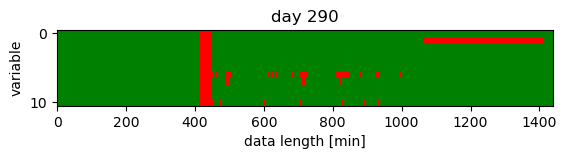

In [12]:
# visualize missing data
N = 5
days = np.random.choice(data.shape[0], N, replace=False)
na_visualizer(days, data)

In [145]:
# missing data sequences before imputation
#na_sequence_lengths(data)

In [13]:
# imputation
MAX_FILL = 1440 # maximum imputation window (from both sides!)
METHOD = 'linear' # imputation method

data_imputed = imputer(data, max_fill=MAX_FILL, method=METHOD)

C:\Users\jjung\AppData\Local\Temp\ipykernel_38352\141253662.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat2[variable].iloc[day] = np.array(post_imputation.iloc[day])


In [14]:
# missing data sequences after imputation
#na_sequence_lengths(data_imputed)

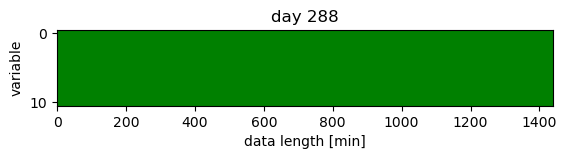

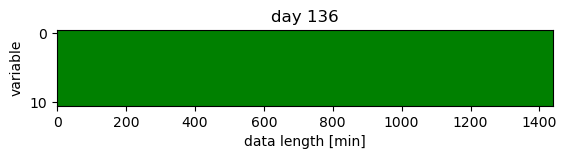

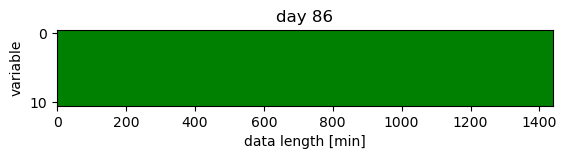

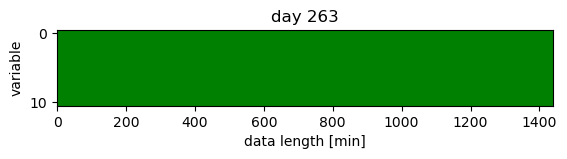

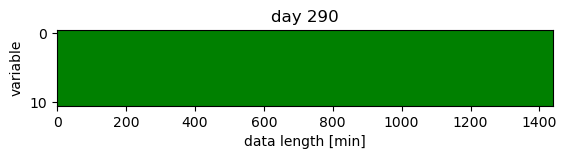

In [41]:
na_visualizer(days, data_imputed)

In [ ]:
# imputation will fill all days until 1440
dat = data_imputed.copy()
for day in [86]:
    length = get_time_series(data, 'ActivityCounts', day).shape[0]
    n_variables = len(VARIABLES)
    na_matrix = np.zeros((n_variables, length))

    for i, variable in enumerate(VARIABLES):
        time_series = get_time_series(dat, variable, day)

        na_data = np.where(np.isnan(time_series), 0.0, 1.0) # NaN -> 0, data -> 1
        print(len(dat[variable].iloc[day]))
        print(len(get_time_series(dat, variable, day)))
        print(na_matrix.shape)
        na_matrix[i, :] = na_data

    # hack: below makes sure colors in image are matched correctly (if all missing/no missing would break otherwise)
    na_matrix[1, 1] = 0.0
    na_matrix[2, 1] = 1.0

    # plot
    cmap = matplotlib.colors.ListedColormap(['red', 'green'])
    plt.figure()
    plt.imshow(na_matrix, cmap=cmap, aspect='20', interpolation='nearest')
    plt.title(f'day {day}')
    plt.xlabel('data length [min]')
    plt.ylabel('variable')

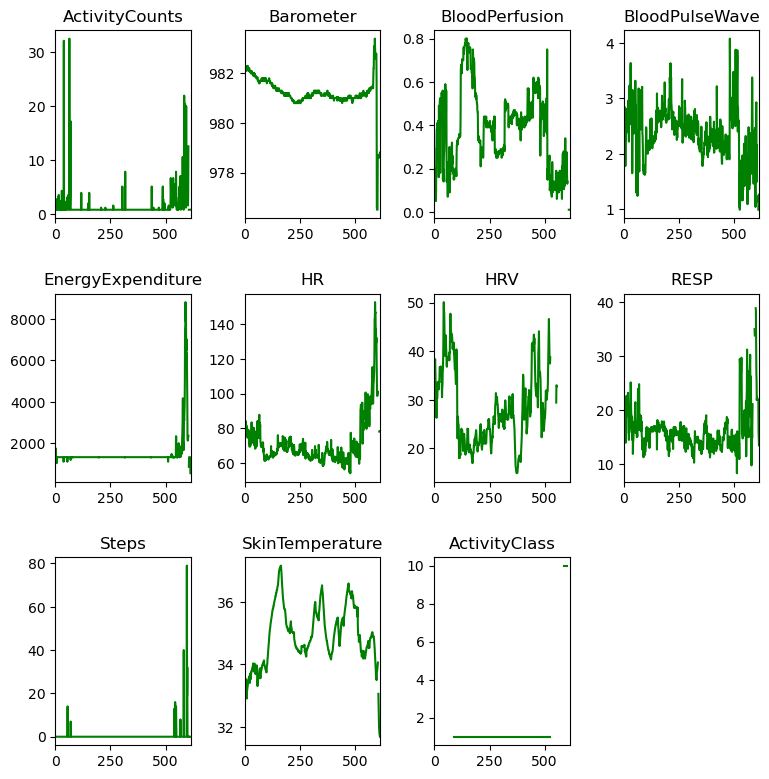

In [37]:
plotter(86, data)

In [39]:
data['HR'].iloc[86]

'80.41533546,83.03548759,78.12299613,78.44957983,82.27808418,84.04247104,80.62070044,81.82153455,79.0904302,80.79877656,77.46507806,75.44277426,76.64470783,74.51506419,79.01136364,75.13811093,79.16028519,77.85706325,78.07551937,76.25907454,71.07342657,72.16261237,69.32858317,72.19430052,70.08671789,69.64411295,74.45437466,70.64570804,72.51901249,76.27168888,79.92110292,83.4084067,78.99159884,73.4969681,73.25329543,75.4503632,71.64758877,73.31339402,74.99861368,72.90603086,80.329683,73.92618837,70.90851002,70.26672264,70.10932568,71.53389385,71.11484594,68.18883415,68.31010453,68.71440021,73.06558328,78.15419028,76.10905125,75.3404908,69.60174881,78.55423534,83.91506849,83.35505618,80.87042156,80.39238515,84.17211229,75.92211609,81.36698771,74.28280044,81.42914305,85.99598071,87.75647852,81.382494,83.14691943,80.41905704,82.05608504,72.18596974,71.54923291,69.94569133,69.20390986,70.68720246,69.77893869,69.89239638,71.17065036,68.98755074,69.97173436,70.95329894,71.9431694,71.81114466,6

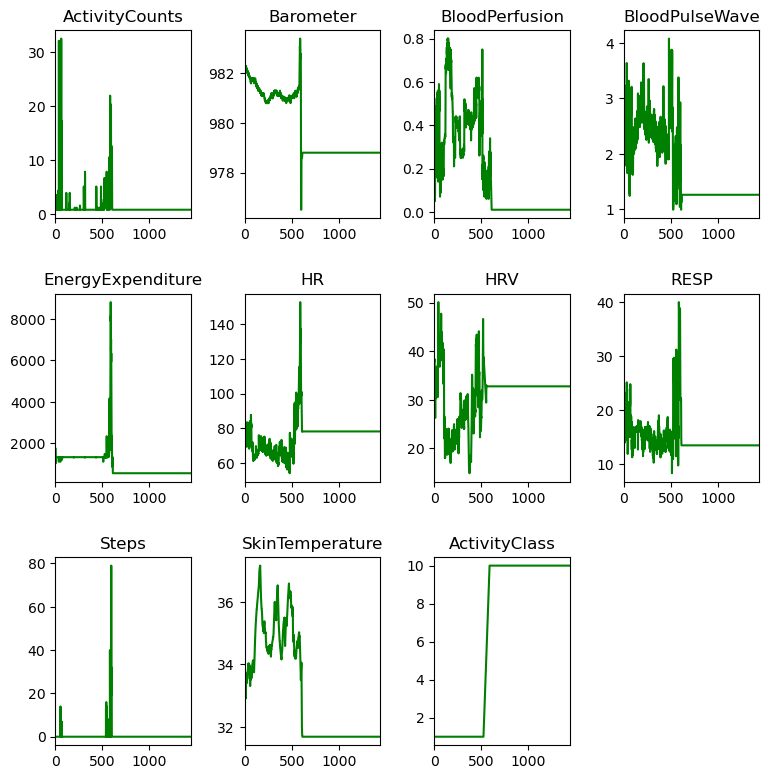

In [38]:
plotter(86, data_imputed)

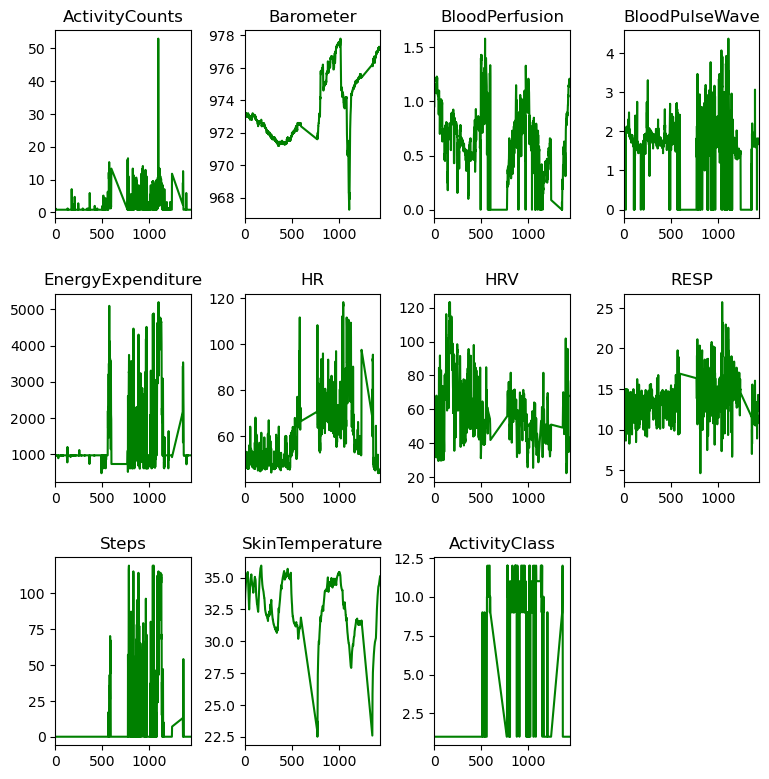

In [42]:
# FOR DEBUGGING
day = 237 # day 237 is good for visualization
#day = np.random.choice(days, 1)[0] # otherwise random day

plotter(day, data_imputed)

# Segmentation

Segment into dataframes with no missing data

In [182]:
# count total time [min] (incl. missing data)
total_time = 0
for day in range(data.shape[0]):
    entry = data[VARIABLES[0]][day]
    time_series = np.array([value if value != 'None' else None for value in entry.split(',')], dtype=float) \
        if not isinstance(entry, np.ndarray) else entry # entry could be ndarray or string

    total_time += len(time_series)

print(f'Total time (incl.missing data) before segmentation: {total_time} min')

Total time (incl.missing data) before segmentation: 568317 min


In [183]:
# segment into dataframes with no missing data
segments = {} # time indices of days (in min)

for day in range(data_imputed.shape[0]):
    entry = np.array([value if value != 'None' else None for value in data_imputed['ActivityCounts'][day].split(',')], dtype=float) \
        if not isinstance(data_imputed['ActivityCounts'][day], np.ndarray) else data_imputed['ActivityCounts'][day] # entry could be ndarray or string

    # check where is missing data
    na_matrix = np.zeros((len(VARIABLES), entry.shape[0]))
    for i, variable in enumerate(VARIABLES):
        entry = data_imputed[variable][day]
        time_series = np.array([value if value != 'None' else None for value in entry.split(',')], dtype=float) \
            if not isinstance(entry, np.ndarray) else entry # entry could be ndarray or string

        na_data = np.where(np.isnan(time_series), 0.0, 1.0) # 0.0: NA, 1.0: data
        na_matrix[i, :] = na_data

    # segment
    segments_indices = []
    segment_start_col = 0
    segment_end_col = 0

    rows, cols = na_matrix.shape
    for col in range(cols):
        # check if NA in column
        if 0.0 in na_matrix[:, col]:
            # check if data before
            if segment_start_col != segment_end_col:
                segments_indices.append((segment_start_col, segment_end_col))

            segment_end_col = segment_start_col = col

        # accept column into segment sequence
        segment_end_col = col

    # check if final sequence contains data
    if segment_start_col != segment_end_col:
        segments_indices.append((segment_start_col, segment_end_col))

    segments[day] = segments_indices

In [184]:
segments

{0: [],
 1: [],
 2: [],
 3: [],
 4: [],
 5: [],
 6: [],
 7: [(0, 191)],
 8: [(0, 604)],
 9: [(0, 494), (596, 1177), (1265, 1439)],
 10: [(0, 1130), (1170, 1439)],
 11: [(0, 507), (521, 626), (776, 998), (1052, 1439)],
 12: [(0, 512), (619, 1439)],
 13: [(0, 447), (642, 764), (832, 1005), (1018, 1153), (1186, 1439)],
 14: [(0, 419), (454, 555), (557, 759), (773, 1152), (1174, 1439)],
 15: [(0, 488), (579, 756), (864, 1439)],
 16: [(410, 720), (728, 1439)],
 17: [(0, 871)],
 18: [(0, 478), (512, 1439)],
 19: [(0, 476), (481, 1439)],
 20: [(0, 479), (500, 1439)],
 21: [(14, 550), (555, 642), (1080, 1439)],
 22: [(0, 688)],
 23: [(0, 804), (822, 1120), (1258, 1439)],
 24: [(0, 400), (569, 941), (992, 1206), (1223, 1439)],
 25: [(429, 555), (726, 852), (909, 1141), (1164, 1403)],
 26: [(429, 821), (993, 1251)],
 27: [(421, 1439)],
 28: [(494, 600)],
 29: [(0, 54), (1224, 1439)],
 30: [(490, 598), (1145, 1252)],
 31: [(389, 560), (593, 756), (855, 974)],
 32: [(951, 1439)],
 33: [(0, 455), (

In [185]:
discarded_days = sum([1 if len(sequence) == 0 else 0 for sequence in segments.values()])
print(f'Discarded days because of missing data in at least one variable: {discarded_days}')
print(f'Days left: {data.shape[0] - discarded_days}')

Discarded days because of missing data in at least one variable: 8
Days left: 402


In [186]:
# count total time [min] (after segmentation)
total_time2 = sum([sum([tupl[1] - tupl[0] + 1 for tupl in sequence]) if len(sequence) != 0 else 0 for sequence in segments.values()])

print(f'Total time after segmentation: {total_time2} min ({round(100 * total_time2 / total_time, 2)}% compared to before)')

Total time after segmentation: 474603 min (83.51% compared to before)


In [187]:
'''segments_size = [tupl[1] - tupl[0] + 1 for sequence in segments.values() for tupl in sequence if len(sequence) != 0]

plt.figure()
plt.hist(segments_size, bins=50)
plt.title(f'Sequences without missing data (total: {len(segments_size)})')
plt.xlabel('Sequence length [min]')

plt.figure()
plt.boxplot(segments_size)'''

"segments_size = [tupl[1] - tupl[0] + 1 for sequence in segments.values() for tupl in sequence if len(sequence) != 0]\n\nplt.figure()\nplt.hist(segments_size, bins=50)\nplt.title(f'Sequences without missing data (total: {len(segments_size)})')\nplt.xlabel('Sequence length [min]')\n\nplt.figure()\nplt.boxplot(segments_size)"

Segment further into overlapping sequences

In [157]:
WINDOW_SIZE = 60 # [min]
OVERLAP = 0.5 # [%]

# Filter sequences

# Spectrogram conversion

In [44]:
SAMPLING_RATE = 1/60

C:\Users\jjung\anaconda3\envs\ai\lib\site-packages\matplotlib\axes\_axes.py:7622: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


<Figure size 640x480 with 0 Axes>

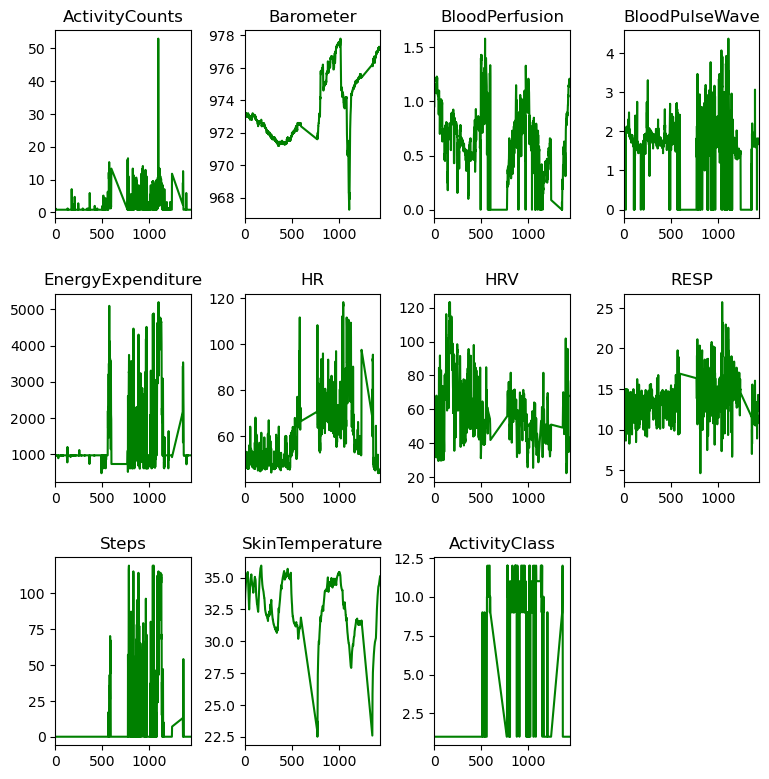

<Figure size 640x480 with 0 Axes>

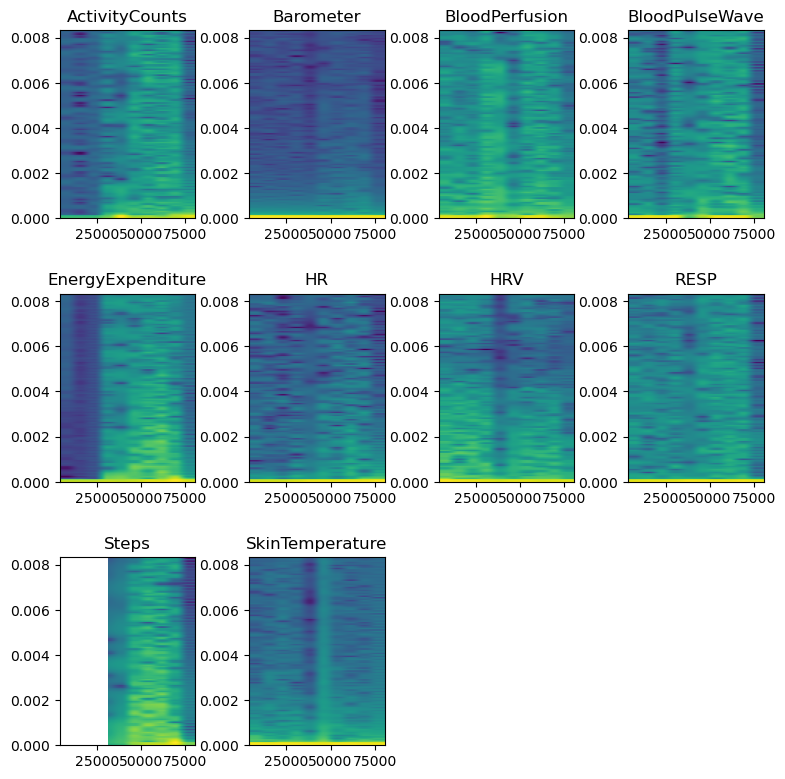

In [45]:
#from scipy import signal
def plotter_spec(day, dat):
    plt.figure()
    plt.subplots_adjust(left=0.1,
                        bottom=0.01,
                        right=1.2,
                        top=1.5,
                        wspace=0.4,
                        hspace=0.4)
    length = len(np.array([value if value != 'None' else None for value in dat['HR'][day].split(',')], dtype=float)) \
        if not isinstance(dat['HR'][day], np.ndarray) else len(dat['HR'][day]) # entry could be ndarray or string

    for i, variable in enumerate(VARIABLES):
        entry = dat[variable][day]
        time_series = np.array([value if value != 'None' else None for value in entry.split(',')], dtype=float) \
            if not isinstance(entry, np.ndarray) else entry # entry could be ndarray or string

        assert len(time_series) == length, 'time-series data lengths differ!'

        col = 'green' if dat['VAS'][day] == 0.0 else 'red'
        if variable != 'ActivityClass': # TODO: ActivityClass is categorical variable
            plt.subplot(3, 4, i+1)
            plt.title(variable)
            #plt.specgram(time_series, NFFT=128, Fs=10e7, noverlap=120, cmap='jet_r')
            plt.specgram(time_series, Fs=SAMPLING_RATE)
            #f, t, Sxx = signal.spectrogram(time_series, 10e3)
            #plt.pcolormesh(t, f, Sxx, shading='gouraud')

            #plt.xlim([0, length])

day = 237

fig = plt.figure()
plotter(day, data_imputed)

fig = plt.figure()
plotter_spec(day, data_imputed)

(1200,)


(array([[2.45156859e+07, 2.43866429e+07, 2.45341726e+07, ...,
                    nan,            nan,            nan],
        [1.27608040e+07, 1.28202667e+07, 1.24776708e+07, ...,
                    nan,            nan,            nan],
        [1.26649247e+04, 3.81217363e+04, 2.94493349e+03, ...,
                    nan,            nan,            nan],
        ...,
        [7.57851448e+02, 1.51804534e+03, 1.12134092e+01, ...,
                    nan,            nan,            nan],
        [7.60413387e+02, 8.91559680e+02, 3.79260889e+01, ...,
                    nan,            nan,            nan],
        [5.84577623e+02, 5.30209845e+01, 6.23267982e+01, ...,
                    nan,            nan,            nan]]),
 array([0.00000000e+00, 6.51041667e-05, 1.30208333e-04, 1.95312500e-04,
        2.60416667e-04, 3.25520833e-04, 3.90625000e-04, 4.55729167e-04,
        5.20833333e-04, 5.85937500e-04, 6.51041667e-04, 7.16145833e-04,
        7.81250000e-04, 8.46354167e-04, 9.1145833

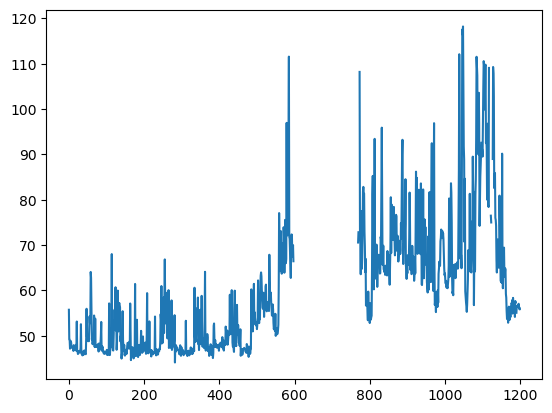

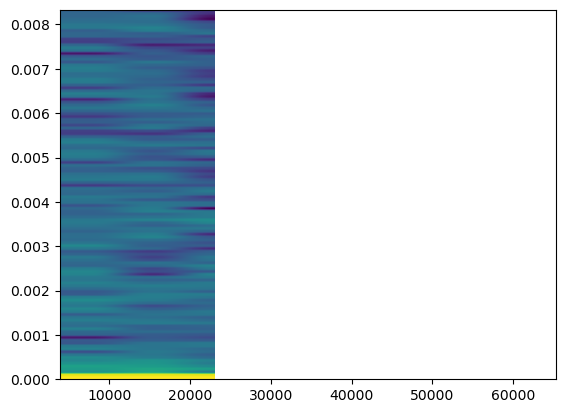

In [435]:
entry = data['HR'][237]
time_series = np.array([value if value != 'None' else None for value in entry.split(',')], dtype=float) \
    if not isinstance(entry, np.ndarray) else entry # entry could be ndarray or string
time_series = time_series.copy()[:1200]
print(time_series.shape)
plt.plot(time_series)
plt.figure()
plt.specgram(time_series, Fs=SAMPLING_RATE)

(array([[2.45156859e+07, 2.43866429e+07, 2.45341726e+07, ...,
                    nan,            nan, 5.37267336e+07],
        [1.27608040e+07, 1.28202667e+07, 1.24776708e+07, ...,
                    nan,            nan, 2.47922413e+07],
        [1.26649247e+04, 3.81217363e+04, 2.94493349e+03, ...,
                    nan,            nan, 7.33834130e+04],
        ...,
        [7.57851448e+02, 1.51804534e+03, 1.12134092e+01, ...,
                    nan,            nan, 1.64398627e+03],
        [7.60413387e+02, 8.91559680e+02, 3.79260889e+01, ...,
                    nan,            nan, 4.33424483e+03],
        [5.84577623e+02, 5.30209845e+01, 6.23267982e+01, ...,
                    nan,            nan, 3.60101498e+02]]),
 array([0.00000000e+00, 6.51041667e-05, 1.30208333e-04, 1.95312500e-04,
        2.60416667e-04, 3.25520833e-04, 3.90625000e-04, 4.55729167e-04,
        5.20833333e-04, 5.85937500e-04, 6.51041667e-04, 7.16145833e-04,
        7.81250000e-04, 8.46354167e-04, 9.1145833

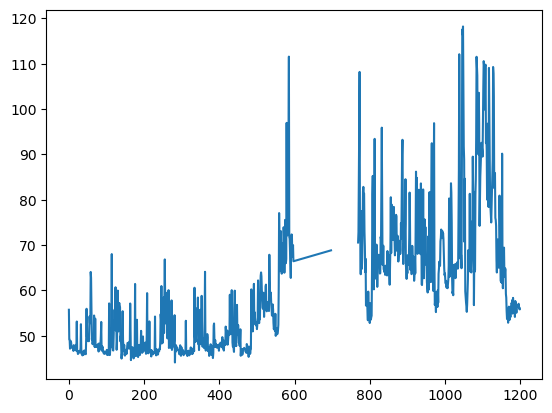

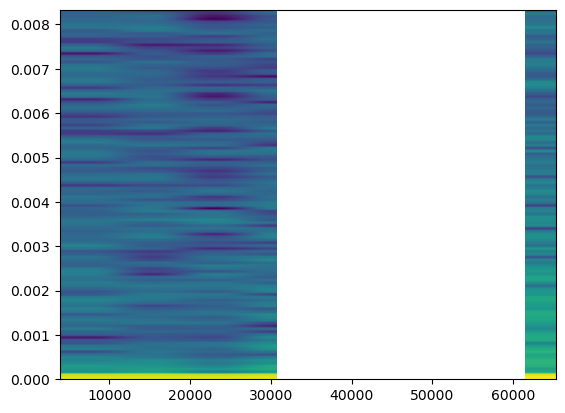

In [162]:
entry = data['HR'][237]
time_series = np.array([value if value != 'None' else None for value in entry.split(',')], dtype=float) \
    if not isinstance(entry, np.ndarray) else entry # entry could be ndarray or string
time_series = time_series.copy()[:1200]
time_series = pd.DataFrame(time_series)
time_series = time_series.interpolate(method='linear', axis=0, limit=100)
temp = time_series.to_numpy().reshape((1200, ))
plt.plot(time_series)
plt.figure()
plt.specgram(temp, Fs=SAMPLING_RATE)

(array([[2.45156859e+07, 2.43866429e+07, 2.45341726e+07, ...,
                    nan, 4.98458854e+07, 5.37267336e+07],
        [1.27608040e+07, 1.28202667e+07, 1.24776708e+07, ...,
                    nan, 2.65705941e+07, 2.47922413e+07],
        [1.26649247e+04, 3.81217363e+04, 2.94493349e+03, ...,
                    nan, 1.38916587e+04, 7.33834130e+04],
        ...,
        [7.57851448e+02, 1.51804534e+03, 1.12134092e+01, ...,
                    nan, 2.93563718e+02, 1.64398627e+03],
        [7.60413387e+02, 8.91559680e+02, 3.79260889e+01, ...,
                    nan, 7.64139304e+02, 4.33424483e+03],
        [5.84577623e+02, 5.30209845e+01, 6.23267982e+01, ...,
                    nan, 5.12711536e+02, 3.60101498e+02]]),
 array([0.00000000e+00, 6.51041667e-05, 1.30208333e-04, 1.95312500e-04,
        2.60416667e-04, 3.25520833e-04, 3.90625000e-04, 4.55729167e-04,
        5.20833333e-04, 5.85937500e-04, 6.51041667e-04, 7.16145833e-04,
        7.81250000e-04, 8.46354167e-04, 9.1145833

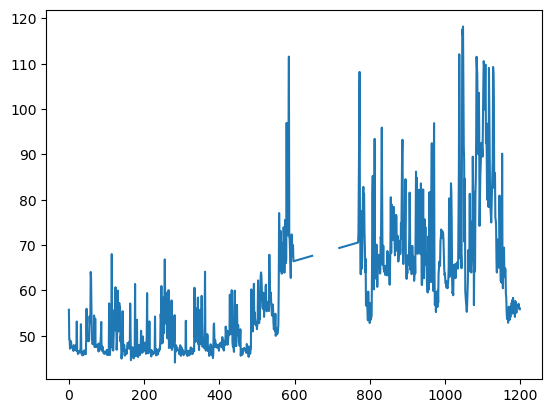

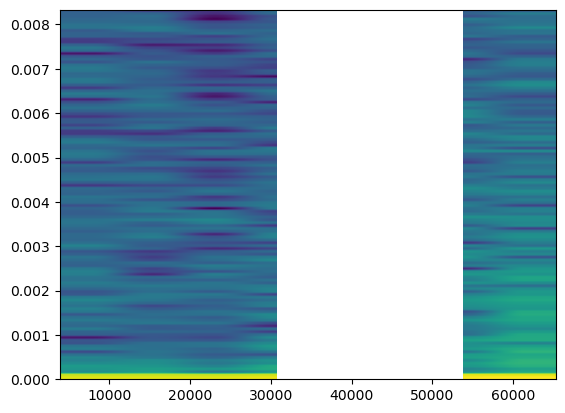

In [164]:
entry = data['HR'][237]
time_series = np.array([value if value != 'None' else None for value in entry.split(',')], dtype=float) \
    if not isinstance(entry, np.ndarray) else entry # entry could be ndarray or string
time_series = time_series.copy()[:1200]
time_series = pd.DataFrame(time_series)
time_series = time_series.interpolate(method='linear', axis=0, limit=50, limit_direction='both')
temp = time_series.to_numpy().reshape((1200, ))
plt.plot(time_series)
plt.figure()
plt.specgram(temp, Fs=SAMPLING_RATE)

(array([[2.45156859e+07, 2.43866429e+07, 2.45341726e+07, ...,
         4.86938458e+07, 4.98458854e+07, 5.37267336e+07],
        [1.27608040e+07, 1.28202667e+07, 1.24776708e+07, ...,
         2.51680198e+07, 2.65705941e+07, 2.47922413e+07],
        [1.26649247e+04, 3.81217363e+04, 2.94493349e+03, ...,
         5.73182140e+04, 1.38916587e+04, 7.33834130e+04],
        ...,
        [7.57851448e+02, 1.51804534e+03, 1.12134092e+01, ...,
         1.39321453e+03, 2.93563718e+02, 1.64398627e+03],
        [7.60413387e+02, 8.91559680e+02, 3.79260889e+01, ...,
         1.92764112e+03, 7.64139304e+02, 4.33424483e+03],
        [5.84577623e+02, 5.30209845e+01, 6.23267982e+01, ...,
         9.01977132e+02, 5.12711536e+02, 3.60101498e+02]]),
 array([0.00000000e+00, 6.51041667e-05, 1.30208333e-04, 1.95312500e-04,
        2.60416667e-04, 3.25520833e-04, 3.90625000e-04, 4.55729167e-04,
        5.20833333e-04, 5.85937500e-04, 6.51041667e-04, 7.16145833e-04,
        7.81250000e-04, 8.46354167e-04, 9.1145833

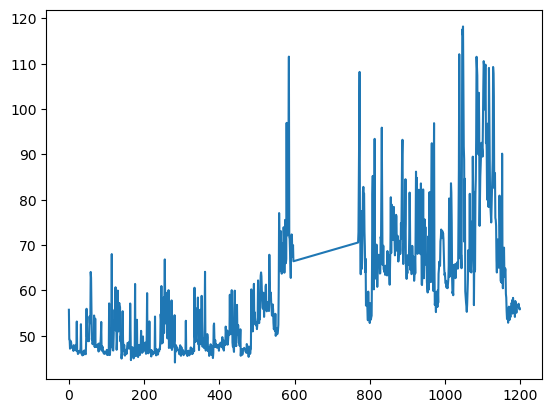

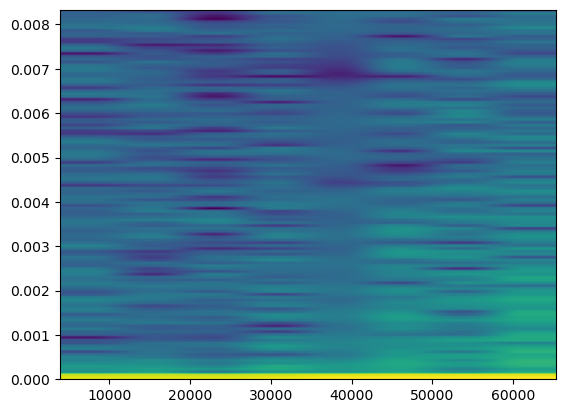

In [437]:
entry = data['HR'][237]
time_series = np.array([value if value != 'None' else None for value in entry.split(',')], dtype=float) \
    if not isinstance(entry, np.ndarray) else entry # entry could be ndarray or string
time_series = time_series.copy()[:1200]
time_series = pd.DataFrame(time_series)
time_series = time_series.interpolate(method='linear', axis=0)
temp = time_series.to_numpy().reshape((1200, ))
plt.plot(time_series)
plt.figure()
plt.specgram(temp, Fs=SAMPLING_RATE)

# Feature vector

ReIP and timezone into feature vector